# Milestone 3 - EDA

# what is my aim with EDA? 
- Explore the dataset, understand what might be driving the machine failures.
- forecast when the machine might fail.

In [ ]:
# Imports 
import DataFrameInfo_class as info
import pandas as pd 
import numpy as np
from scipy.stats import normaltest 
from scipy import stats
from statsmodels.graphics.gofplots import qqplot 
import matplotlib.pyplot as plt
import seaborn as sns
import DataFrameInfo_class as info
from IPython.display import display
from scipy.stats import pointbiserialr

In [ ]:
class DataFrameInfo:
    def __init__(self, df):
        self.df = df 
    
    def return_shape(self):
        return str(self.df.shape) 
    
    def return_info(self):
        return self.df.info()
    
    def return_first_row(self):
         return self.df.iloc[0]

    def data_type(self):
        print(self.df.dtypes)
    
    def describe_statistics(self):
        return self.df.describe().loc[['mean', 'std', '50%']]
    
    def unique_value_count(self, column_names):
        return self.df[column_names].nunique()
    
    def percentage_of_null(self):
        percentage_of_null = self.df.isnull().sum() / len(self.df) * 100  
        return percentage_of_null
    
    def are_all_observations_unique(self, column_name):
        print(f'The {column_name} column contains only unique rows: {len(self.df) == self.df[column_name].nunique()}')
    
    def normal_test(self, column_name):
        stat, p = normaltest(self.df[column_name], nan_policy = 'omit')
        print('Statistics=%.3f, p=%.3f' % (stat, p))

    def print_mean(self, column_name):
        print(f'The mean of {column_name} is {self.df[column_name].mean()}')
    
    def print_median(self, column_name):
        print(f'The median of {column_name} is {self.df[column_name].median()}')

    def column_names(self):
        return self.df.columns

    def continous_variables(self):
        continous_variables = []
        for i in self.df.columns:
            if self.df[i].nunique() > 2:
                continous_variables.append(i)
        return continous_variables
    
    def z_score_info(self, z_scores):
        # Z-score Threshold 
        threshold_2 = 2 
        threshold_3 = 3
        # z_scores = udi_process_temp_df_z['z_scores']

        outliers_2 = (np.abs(z_scores) > threshold_2).sum() 
        outliers_3 = (np.abs(z_scores) > threshold_3).sum()

        percentage_outliers_thereshold_2 = round(outliers_2/len(z_scores) * 100, 2)
        percentage_outliers_thereshold_3 = round(outliers_3/len(z_scores) * 100, 2)

        print(f"Number of observations with outliers based on z-score threshold ±2: {outliers_2}")
        print(f"Percentage of observations with outliers based on z-score threshold ±2: {percentage_outliers_thereshold_2}")
        print("\n")
        print(f"Number of observations with outliers based on z-score threshold ±3: {outliers_3}")
        print(f"Percentage of observations with outliers based on z-score threshold ±3: {percentage_outliers_thereshold_3}")

In [ ]:
class DataTransform:
    def __init__(self, df):
        self.df = df
        #self.info = df.info()

    def unique_observations(self, column_name):
        return self.df[column_name].unique()
    
    def convert_column_to_category(self, column_name):
        '''
        converts the dtype of column to 'category'
        '''
        self.df[column_name] = pd.Categorical(self.df[column_name])
        return self.df
    
    def create_dummies_from_column(self, column_name):
        dummies_df = pd.get_dummies(self.df[column_name], dtype=int)
        return dummies_df 

    def concat_dataframes(self, new_df, left_index=True, right_index=True):
        '''
        This functions joins on the index of the LEFT DataFrame
        '''
        joined_df = pd.concat([self.df, new_df], axis = 1)
        return joined_df
    
    def yeojohnson(self, column_name):
        yeojohnson_var = self.df[column_name]
        yeojohnson_var, _ = stats.yeojohnson(yeojohnson_var) # The '_' ignores the second parameter, in this case it is the lambda parameter 
        yeojohnson_var = pd.Series(yeojohnson_var)
        return yeojohnson_var
    
    def z_score(self, column): # takes in a column and creates z scores, 
        x = self.df[column] 
        mean= np.mean(x)
        standard_deviation = np.std(x)
        z_scores = (x - mean) / standard_deviation
        return z_scores
    
    def outliers_via_z_score_df(self, column, z_threshold = [[2,3]]):

        '''
        returns a df of outliers based on the z_scores of a selected variable
        '''
        # create z scores
        x = self.df[column] 
        mean= np.mean(x)
        standard_deviation = np.std(x)
        z_scores = (x - mean) / standard_deviation

        # calculate outliers 
        outliers = np.abs(z_scores) > z_threshold

        # outliers df
        outliers_via_z = self.df[outliers]
        return outliers_via_z

    def filter_outliers(self, outliers_df, key_ID):
        '''
        Filters outliers from df. 
        Use in conjuction with outliers_via_z_score func.
        '''
        mask = ~self.df[key_ID].isin(outliers_df[key_ID]) # if the UDI's in the outliers df match those in the original df, bring back FALSE
        mask
        print(f'length of original df: {len(self.df)}')
        print(f'length of filtered df: {len(self.df[mask])}')
        return self.df[mask]
    
    def outliers_df_via_IQR(self, column):

        # Upper and lower quartiles 
        Q1 = self.df[column].quantile(0.25)
        Q3 = self.df[column].quantile(.75)

        # 
        IQR = Q3 - Q1 

        print(f"Q1 (25th percentile): {Q1}")
        print(f"Q1 (75th percentile): {Q3}")
        print(f"IQR: {IQR}")

        var = self.df[column]

        # Identify outliers 
        outliers = self.df[(var < (Q1 - 1.5 * IQR)) | (var > (Q3 + 1.5 * IQR))]
        return outliers

In [ ]:
# Plotter Class

class Plotter: 
    def __init__(self, df):
        self.df = df 
    
    def plot_hist(self, column_name):
        self.df[column_name].hist(bins = 40)
        plt.show()
    
    def plot_qq(self, column_name):
        qq_plot= qqplot(self.df[column_name], scale=1, line ='q')
        plt.show()
    
    def scatter(self, column_name):
        scatter_plot = sns.scatterplot(self.df[column_name])
        plt.show()
        
    def boxplot(self, column):
        box_plot = sns.boxplot(self.df[column])
        plt.show()

# Convert columns to the correct format 

In [107]:
# Load the Data into a data frame 
failure_data = pd.read_csv("failure_data.csv")

# head of df 
failure_data.head(3)


,Unnamed: 0,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,3416,L50595,L,301.4,310.4,1579,36.9,133.0,0,0,0,0,0,0
1,1,7130,L54309,L,300.6,310.0,1635,31.0,107.0,0,0,0,0,0,0
2,2,2320,M17179,M,299.2,308.8,1700,33.5,185.0,0,0,0,0,0,0


In [117]:
# Check the first row of the Data 
info = DataFrameInfo(failure_data)
# First row
info.return_first_row()

Unnamed: 0                      0
UDI                          3416
Product ID                 L50595
Type                            L
Air temperature [K]         301.4
Process temperature [K]     310.4
Rotational speed [rpm]       1579
Torque [Nm]                  36.9
Tool wear [min]             133.0
Machine failure                 0
TWF                             0
HDF                             0
PWF                             0
OSF                             0
RNF                             0
Name: 0, dtype: object

In [109]:
# Is UDI a unique key for the data?
info = DataFrameInfo(failure_data)
print(f'UDI is unique to every row of the data: {info.unique_value_count('UDI') == len(failure_data)}')

UDI is unique to every row of the data: True


In [110]:
# Initial information about the data 
print(f'The shape of the data is: {info.return_shape()}')

print('\n')
print(f'Initial information about the columns of the data: ')
print(info.return_info())

# transform.return_info()

The shape of the data is: (10000, 15)


Initial information about the columns of the data: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               10000 non-null  int64  
 1   UDI                      10000 non-null  int64  
 2   Product ID               10000 non-null  object 
 3   Type                     10000 non-null  object 
 4   Air temperature [K]      9162 non-null   float64
 5   Process temperature [K]  9119 non-null   float64
 6   Rotational speed [rpm]   10000 non-null  int64  
 7   Torque [Nm]              10000 non-null  float64
 8   Tool wear [min]          9516 non-null   float64
 9   Machine failure          10000 non-null  int64  
 10  TWF                      10000 non-null  int64  
 11  HDF                      10000 non-null  int64  
 12  PWF                      10000 non-null

In [94]:
# Categoric variables 
categorical_vars = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF','RNF']
print(f'Categorical variables: {categorical_vars}')

Categorical variables: ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


Change the `Dtype` label in the DataFrame to categorical for the above variables

In [118]:
#Data Transform Methods
dt = DataTransform(failure_data)

# Applying the `categorical` data label to the relevant columns 
categorical_columns = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF','RNF']
for i in categorical_columns:
    failure_data_v1= dt.convert_column_to_category(i)
    # print(failure_data.info())

print(failure_data_v1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Unnamed: 0               10000 non-null  int64   
 1   UDI                      10000 non-null  int64   
 2   Product ID               10000 non-null  object  
 3   Type                     10000 non-null  object  
 4   Air temperature [K]      9162 non-null   float64 
 5   Process temperature [K]  9119 non-null   float64 
 6   Rotational speed [rpm]   10000 non-null  int64   
 7   Torque [Nm]              10000 non-null  float64 
 8   Tool wear [min]          9516 non-null   float64 
 9   Machine failure          10000 non-null  category
 10  TWF                      10000 non-null  category
 11  HDF                      10000 non-null  category
 12  PWF                      10000 non-null  category
 13  OSF                      10000 non-null  category
 14  RNF    

In [112]:
print(f'`Type` contains the following unique variables: {failure_data['Type'].unique()}')

`Type` contains the following unique variables: ['L' 'M' 'H']


Convert `Type` to dummy variables.
- Motivation: handling categorical data to be used in statistical models e.g. Logit Model or Machine Learning Models.

In [116]:
# Convert `Type` into dummies & join them onto our original df 
dt = DataTransform(failure_data_v1)
type_as_dummies = dt.create_dummies_from_column('Type')
failure_data_v2 = dt.concat_dataframes(type_as_dummies)
failure_data_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Unnamed: 0               10000 non-null  int64   
 1   UDI                      10000 non-null  int64   
 2   Product ID               10000 non-null  object  
 3   Type                     10000 non-null  object  
 4   Air temperature [K]      9162 non-null   float64 
 5   Process temperature [K]  9119 non-null   float64 
 6   Rotational speed [rpm]   10000 non-null  int64   
 7   Torque [Nm]              10000 non-null  float64 
 8   Tool wear [min]          9516 non-null   float64 
 9   Machine failure          10000 non-null  category
 10  TWF                      10000 non-null  category
 11  HDF                      10000 non-null  category
 12  PWF                      10000 non-null  category
 13  OSF                      10000 non-null  category
 14  RNF    

In [120]:
# Apply categoric labels to the `Type` dummy variables 
dt = DataTransform(failure_data_v2)
type_dummy_col_names = ['L', 'M', 'H']
for i in type_dummy_col_names:
    failure_data_v3 = dt.convert_column_to_category(i)

# Check if the Dtype has changed
failure_data_v3.info()

In [122]:
# rename data set 
failure_data = failure_data_v3

# Remove / impute missing values 

- See plotter_v2 for the reasoning

In [14]:
# The following Data Transformation act as a treatement to missing data in the data set 

# Treating the NULL values 
failure_data['Air temperature [K]'] = failure_data['Air temperature [K]'].fillna(failure_data['Air temperature [K]'].median())
failure_data['Process temperature [K]'] = failure_data['Process temperature [K]'].fillna(failure_data['Process temperature [K]'].median())
failure_data.dropna(subset='Tool wear [min]', inplace=True)
# create a new variable after treating the null variables
failure_data_without_null = failure_data

# TODO: include the resoning from plotter_v2 
# TODO: update the Data transformation class with a method for checking if the data has NULL values and methods for the above data transformations 

In [15]:
# Prove that the new transformed data contails no missing values 
info_df_without_null = DataFrameInfo(failure_data_without_null)
info_df_without_null.percentage_of_null()

UDI                        0.0
Product ID                 0.0
Type                       0.0
Air temperature [K]        0.0
Process temperature [K]    0.0
Rotational speed [rpm]     0.0
Torque [Nm]                0.0
Tool wear [min]            0.0
Machine failure            0.0
TWF                        0.0
HDF                        0.0
PWF                        0.0
OSF                        0.0
RNF                        0.0
H                          0.0
L                          0.0
M                          0.0
dtype: float64

# Investigating for Skewness in the data 

<Axes: >

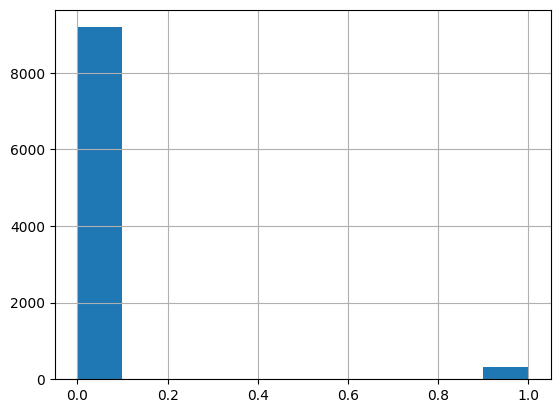

In [16]:
# measuring skewness 
# Begin with our dependant variable "Machine failure". As it's binary data, we will visualise the frequency of the data 

failure_data_without_null['Machine failure'].hist()

# Strongly biased towards `0` indicating that majority of the data gives information about machines that did NOT fail during the manufacturing process.


In [17]:
# Identify variables with continuous data types. 
# Continous data is defined by data with more than two unique values 
# create a table with the variable names and another column for variable data type 
variable_name = []
variable_description = []


for i in failure_data_without_null.columns:
    variable_name.append(i)
    if failure_data_without_null[i].nunique() > 2:
        variable_description.append("continous data")
    else:
        variable_description.append('other data type')



variable_info = pd.DataFrame({
    'variable_name': variable_name,
    'variable_description': variable_description
})

display(variable_info)

,variable_name,variable_description
0,UDI,continous data
1,Product ID,continous data
2,Type,continous data
3,Air temperature [K],continous data
4,Process temperature [K],continous data
5,Rotational speed [rpm],continous data
6,Torque [Nm],continous data
7,Tool wear [min],continous data
8,Machine failure,other data type
9,TWF,other data type


In [18]:
# filter for the variables that are the 'other data type' 

print(failure_data_without_null[['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M']])
# It is clear that all the 'other data types' are binary data 
# change the labelling 
variable_info['variable_description'] = variable_info['variable_description'].replace('other data type', 'binary')


display(variable_info)

      TWF  HDF  PWF  OSF  RNF  H  L  M
0       0    0    0    0    0  0  1  0
1       0    0    0    0    0  0  1  0
2       0    0    0    0    0  0  0  1
3       0    0    0    0    0  0  0  1
4       0    0    0    0    0  0  1  0
...   ...  ...  ...  ...  ... .. .. ..
9995    0    0    0    0    0  0  0  1
9996    0    0    0    0    0  0  0  1
9997    0    0    0    0    0  0  1  0
9998    0    0    0    0    0  0  1  0
9999    0    0    0    0    0  0  1  0

[9516 rows x 8 columns]


,variable_name,variable_description
0,UDI,continous data
1,Product ID,continous data
2,Type,continous data
3,Air temperature [K],continous data
4,Process temperature [K],continous data
5,Rotational speed [rpm],continous data
6,Torque [Nm],continous data
7,Tool wear [min],continous data
8,Machine failure,binary
9,TWF,binary


<Axes: >

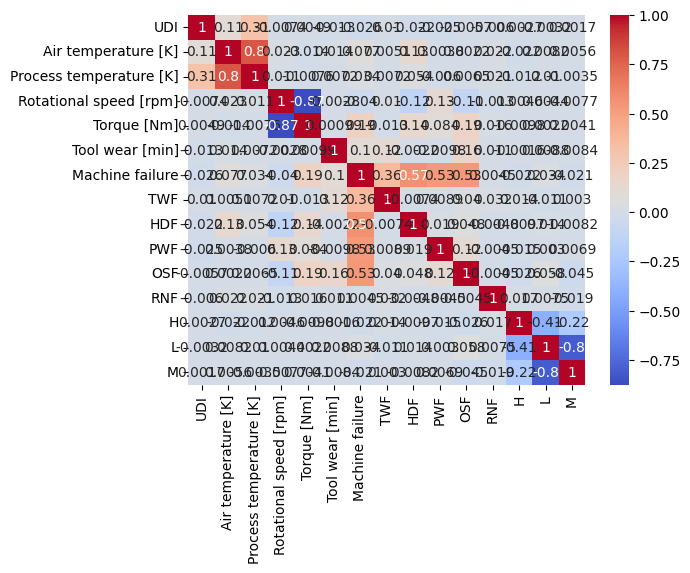

In [22]:
# Correlation Heatmap

#DataTransformation
# drop unwanted columns with str() type observations
# failure_data_without_null.drop(['Type', 'Product ID'], axis = 1, inplace=True)

# Heatmap 
sns.heatmap(failure_data_without_null.corr(), cmap= 'coolwarm', annot=True )

#failure_data_without_null

<Axes: >

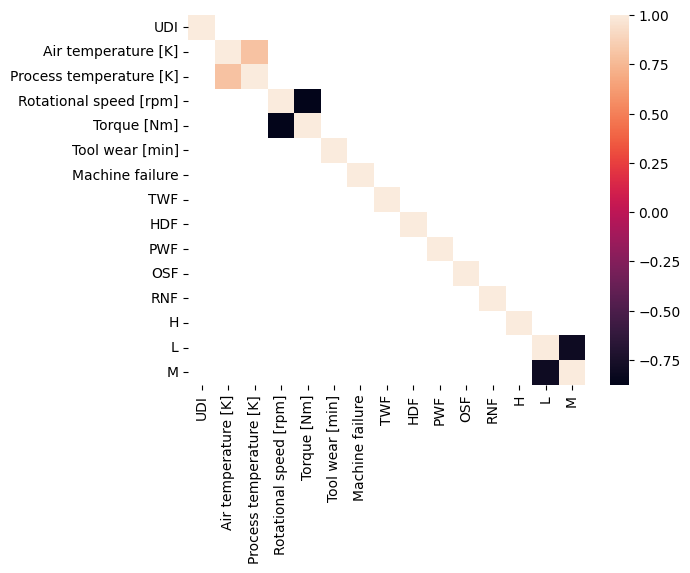

In [23]:
corr = failure_data_without_null.corr()
mask = np.abs(corr) > 0.75
high_corr = corr[mask]
sns.heatmap(high_corr)

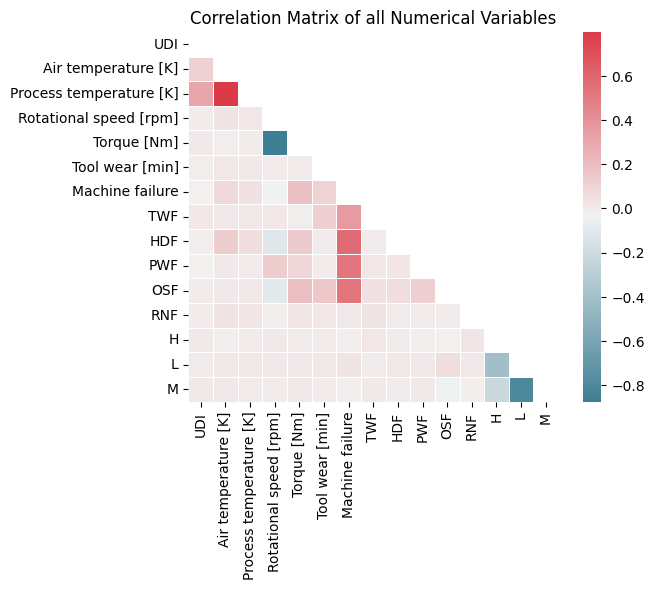

In [24]:
corr = failure_data_without_null.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# set thins up for plotting
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, 
            square=True, linewidths=.5, annot=False, cmap=cmap)
plt.yticks(rotation=0)
plt.title('Correlation Matrix of all Numerical Variables')
plt.show()

- The dependant variable `Machine failure` is binary, therefore the above Pearsons's correlation approach is only appropriate for two continous variables. 
- Use Point-biserial correlation coefficient (PBC) instead. This is specifically designed for the case where the dependant variable is binary.

#### Point-biserial correlation
- It ranges from −1 to 1, where −1 indicates a perfect negative association between the variables, 0 indicates no association, and 1 indicates a perfect positive association.

In [25]:
# Example using the dependant variable and `Air Temperature `

# Calculate the point-biserial correlation and p-value
r_pb, p_value = pointbiserialr(failure_data_without_null['Machine failure'], failure_data_without_null['Air temperature [K]'])

# Print the results with an explainable statement
print(f"The point-biserial correlation coefficient between 'Machine failure' and 'Air temperature [K]' is {round(r_pb, 3)} with a p-value of {round(p_value, 4)}.")
print("The null hypothesis is that there is no correlation between 'Machine failure' and 'Air temperature [K]' (r_pb = 0).")

# Interpretation of the p-value
if p_value < 0.05:
    print("Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a significant correlation.")
else:
    print("Since the p-value is greater than 0.05, we fail to reject the null hypothesis and conclude that there is no significant correlation.")

# Interpretation of the r_pb value
if r_pb > 0:
    direction = "positive"
else:
    direction = "negative"

strength = ""
abs_r_pb = abs(r_pb)
if abs_r_pb < 0.1:
    strength = "negligible"
elif abs_r_pb < 0.3:
    strength = "weak"
elif abs_r_pb < 0.5:
    strength = "moderate"
else:
    strength = "strong"

print(f"The correlation is {direction} and the strength of the correlation is {strength}.")


The point-biserial correlation coefficient between 'Machine failure' and 'Air temperature [K]' is 0.077 with a p-value of 0.0.
The null hypothesis is that there is no correlation between 'Machine failure' and 'Air temperature [K]' (r_pb = 0).
Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a significant correlation.
The correlation is positive and the strength of the correlation is negligible.


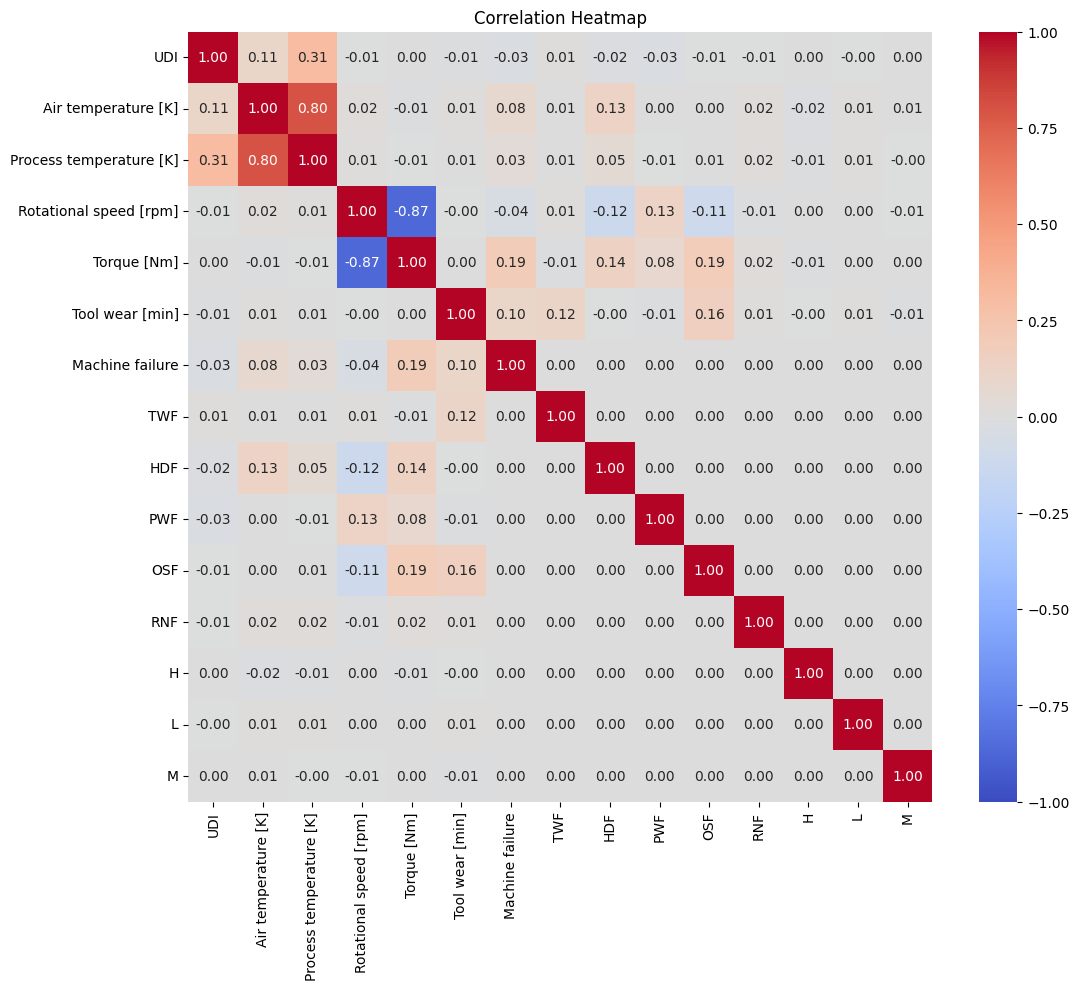

In [26]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Identify binary and continuous variables
binary_vars = [col for col in failure_data_without_null.columns if failure_data_without_null[col].nunique() == 2]
continuous_vars = [col for col in failure_data_without_null.columns if failure_data_without_null[col].dtype in ['int64', 'float64'] and failure_data_without_null[col].nunique() > 2]

# Initialize the correlation matrix
corr_matrix = pd.DataFrame(np.zeros((len(failure_data_without_null.columns), len(failure_data_without_null.columns))), index=failure_data_without_null.columns, columns=failure_data_without_null.columns)

# Compute correlations
for var1 in failure_data_without_null.columns:
    for var2 in failure_data_without_null.columns:
        if var1 == var2:
            corr_matrix.loc[var1, var2] = 1.0  # Correlation with itself is 1
        elif var1 in binary_vars and var2 in continuous_vars:
            r_pb, _ = pointbiserialr(failure_data_without_null[var1], failure_data_without_null[var2])
            corr_matrix.loc[var1, var2] = r_pb
            corr_matrix.loc[var2, var1] = r_pb
        elif var1 in continuous_vars and var2 in continuous_vars:
            r_pearson, _ = pearsonr(failure_data_without_null[var1], failure_data_without_null[var2])
            corr_matrix.loc[var1, var2] = r_pearson
            corr_matrix.loc[var2, var1] = r_pearson

# Plot the heatmap with annotations rounded to 2 decimal places
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
# There is neither a strong positive or negative correlation between `Machine failure` and the independant variables. Look at mesuring skewness of each continous variables

In [ ]:
info.continous_variables()

In [27]:
# Define a function for skewness
    # Takes in the data frame 

info = DataFrameInfo(failure_data_without_null)
# info.normal_test(column_name="UDI")
# info.column_names()

normal_test_result = []

for i in info.continous_variables():
    print(i)
    print('\n')
    print(f'{i} :')
    normal_test_result.append(info.normal_test(i))


    # if p < 0.01:
    #     print('reject the null hypothesis. The data is skewed')
    # else:
    #     print('accept the null hypothesis. The data is normally distributed')

# TODO: fix this 

UDI


UDI :
Statistics=8041.851, p=0.000
Air temperature [K]


Air temperature [K] :
Statistics=406.302, p=0.000
Process temperature [K]


Process temperature [K] :
Statistics=38.432, p=0.000
Rotational speed [rpm]


Rotational speed [rpm] :
Statistics=4249.699, p=0.000
Torque [Nm]


Torque [Nm] :
Statistics=0.370, p=0.831
Tool wear [min]


Tool wear [min] :
Statistics=6306.896, p=0.000


In [ ]:
# Reject the null hypothesis for all continous variables apart from `Torque`. As the p-value suggests fairly strong evidence for a normal distribution for `Torque`
# ignore UDI, as it is a label rather than a explanatory variable for `Machine failure`
# visualise the skew for the variables of interest 
    # Air temperature [K]
    # Process temperature [K]
    # Rotational speed [rpm]
    # Tool wear [min]

# create histograms and qq plots for each

plott = Plotter(failure_data_without_null)

skewed_variables = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Tool wear [min]']
skewed_variables

for i in skewed_variables:
    print(i)
    plott.plot_hist(i)





- Rotational speed [rpm]
- Tool wear [min]



#### Air temperature

In [ ]:
plott.plot_hist('Air temperature [K]')

- `Air temperature [K]`, contains 3 spikes, this likely for each `Type`. Where the Air temperature is higher 'High' quality products and the converse for low quality products 

In [ ]:
plottm = Plotter(failure_data_without_null)
plott.plot_qq('Air temperature [K]')

- Air Temperature Q-Q plot shows that there is deviation from in the lower and upper quartiles of the data set.

In [ ]:
# treating the skewness in Air temperature 
# Box-Cox Transformation. 
    # Motivation - out data is positive 

boxcox_air = failure_data['Air temperature [K]']
boxcox_air = stats.boxcox(boxcox_air) 
boxcox_air = pd.Series(boxcox_air[0])
t=sns.histplot(boxcox_air,label="Skewness: %.2f"%(boxcox_air.skew()) )
t.legend()
# boxcox_air = pd.Series(boxcox_air[0])

In [ ]:
# boxcox transformation, did not work as expected, this is because the variance is relatively small, the points are all concentrated. 

failure_data_without_null['Air temperature [K]']

In [ ]:
# Yeo Johnson transformation
from scipy.stats import yeojohnson
yeojohnson_air = failure_data_without_null['Air temperature [K]']
yeojohnson_air = stats.yeojohnson(yeojohnson_air)
yeojohnson_air= pd.Series(yeojohnson_air[0])
t=sns.histplot(yeojohnson_air,label="Skewness: %.2f"%(yeojohnson_air.skew()) )
t.legend()


In [ ]:
# The YeoJohnson transformation has successfully transformed the data to be symmetrical. The closer the value to zero, the more symmetrical the data. 


In [ ]:
# compare with original distrubution 
plott.plot_hist('Air temperature [K]')

#### Process Temperature [K]

In [ ]:
plott.plot_hist('Process temperature [K]')

- Process temperature [K], contains a spike around 310K and slightly negative skew. This is expected as the increase in temperature maybe due to the variation of products involved, as the quality increases, the process temperature increases. Investigate this with a scatter plot of `Type` vs temperature variables.

In [ ]:
plott.plot_qq('Process temperature [K]')

In [ ]:
# info.continous_variables()

# failure_data_without_null['Air temperature [K]'].skew()

failure_data_without_null 

for i in info.continous_variables():
    print('\n')
    print(i)
    skew = failure_data_without_null[i].skew()
    print(skew)
    if skew > 0.1 or skew < -0.1:
        print('data is skewed and needs treatment')

# FIXTHIS 

### Rotational speed and Air temperature are the only variables with Skewness. 

In [ ]:
# Rotational speed 

plott.plot_hist('Rotational speed [rpm]')
print('histogram shows a positive skew and supports the skew test')

In [ ]:
plott.plot_qq('Rotational speed [rpm]')
print('Severe deviation in the upper bound of the data. Slight deviation in the lower bound')
print('proceed with transformation')

In [ ]:
# As the data is positive and rightly skewed, proceed with a box cox transformation 
log_rotational_speed = failure_data_without_null['Rotational speed [rpm]'].map(lambda i: np.log(i) if i > 0 else 0)
t = sns.histplot(log_rotational_speed, label="Skewness: %.2f"%(log_rotational_speed.skew()))
t.legend()
print("skewness has been reduced, the data is still not symmetrical, proceed with Box-Cox Transformations ")

In [ ]:
boxcox_rotational_speed = failure_data_without_null['Rotational speed [rpm]']
boxcox_rotational_speed = stats.boxcox(boxcox_rotational_speed)
boxcox_rotational_speed = pd.Series(boxcox_population[0])
t = sns.histplot(boxcox_rotational_speed, label="Skewness: %.2f"%(boxcox_rotational_speed.skew()))
t.legend()

# boxcox_rotational_speed.head()

In [ ]:
yeojohnson_rotational_speed = failure_data_without_null['Rotational speed [rpm]']
yeojohnson_rotational_speed = stats.yeojohnson(yeojohnson_rotational_speed)
yeojohnson_rotational_speed = pd.Series(yeojohnson_rotational_speed[0])
yeojohnson_rotational_speed_hist = sns.histplot(yeojohnson_rotational_speed, label = "Skewness: %.2f"%(yeojohnson_rotational_speed.skew()))
yeojohnson_rotational_speed_hist.legend()



In [ ]:
# Rotational Speed Side by side comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Original data histogram
sns.histplot(data=failure_data_without_null, x='Rotational speed [rpm]', ax=ax[0])
original_skewness = failure_data_without_null['Rotational speed [rpm]'].skew()
ax[0].set_title(f'Original Data\nSkewness: {original_skewness:.2f}')
ax[0].set_xlabel('Rotational speed [rpm]')
ax[0].set_ylabel('Count')

# Transformed data histogram
yeojohnson_rotational_speed = failure_data_without_null['Rotational speed [rpm]']
yeojohnson_rotational_speed, _ = stats.yeojohnson(yeojohnson_rotational_speed)
yeojohnson_rotational_speed = pd.Series(yeojohnson_rotational_speed)
yeojohnson_rotational_speed_hist = sns.histplot(yeojohnson_rotational_speed, ax=ax[1])

transformed_skewness = yeojohnson_rotational_speed.skew()
ax[1].set_title(f'Transformed Data\nSkewness: {transformed_skewness:.2f}')
ax[1].set_xlabel('Rotational speed [rpm]')
ax[1].set_ylabel('Count')

# Show plot
plt.suptitle('Comparison of Original and Transformed Data Skewness', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# data transformation 
yeojohnson_rotational_speed = failure_data_without_null['Rotational speed [rpm]']
yeojohnson_rotational_speed, _ = stats.yeojohnson(yeojohnson_rotational_speed)
yeojohnson_rotational_speed = pd.Series(yeojohnson_rotational_speed)


In [ ]:
# Do the same for Air Temperature

# Side by side comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Original data histogram
sns.histplot(data=failure_data_without_null, x='Air temperature [K]', ax=ax[0])
original_skewness = failure_data_without_null['Air temperature [K]'].skew()
ax[0].set_title(f'Original Data\nSkewness: {original_skewness:.2f}')
ax[0].set_xlabel('Air temperature [K]')
ax[0].set_ylabel('Count')

# Transformed data histogram
yeojohnson_air = failure_data_without_null['Air temperature [K]']
yeojohnson_air, _ = stats.yeojohnson(yeojohnson_air) # The '_' ignores the second parameter, in this case it is the lambda parameter 
yeojohnson_air = pd.Series(yeojohnson_air)
yeojohnson_air_hist = sns.histplot(yeojohnson_air, ax=ax[1])
transformed_skewness = yeojohnson_air.skew()
ax[1].set_title(f'Transformed Data\nSkewness: {transformed_skewness:.2f}')
ax[1].set_xlabel('Air temperature [K]')
ax[1].set_ylabel('Count')

# Show plot
plt.suptitle('Comparison of Original and Transformed Data Skewness', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Next steps:
- replace the yeojohnson transformation to air & rotational speed in the orginal data set 
# khurmi



#### Now use the DataTransformation class to add these transformations  

In [ ]:
# create a copy of the data set 
failure_data_cleaned_unskewed = failure_data_without_null.copy(deep=True)

# create a Datatransform instance 
dt = DataTransform(failure_data_cleaned_unskewed)

yeojohnson_air = dt.yeojohnson('Air temperature [K]')
yeojohnson_rotational_speed = dt.yeojohnson('Rotational speed [rpm]')

failure_data_cleaned_unskewed['Air temperature [K]'] = yeojohnson_air
failure_data_cleaned_unskewed['Rotational speed [rpm]'] = yeojohnson_rotational_speed

# failure_data_cleaned_unskewed.head()

# sum(failure_data_without_null['Air temperature [K]'].isnull())

In [ ]:
print('original data set ')
print('\n')
print(failure_data_without_null[['Air temperature [K]', 'Rotational speed [rpm]']])

In [ ]:
print('After skewness transformations')
print('\n')
print(failure_data_cleaned_unskewed[['Air temperature [K]', 'Rotational speed [rpm]']])
print('\n')
print('The transformation for skewness has been made. The interpretability of `Air temperature [K]` and `Rotational speed` has reduced drastically')

# Ask khushboo how tp sort this out.
# TODO: need to change the df  name for after skewness has been applied, this is so that the code is reproducible 

In [ ]:
info_after_skew_transformation = DataFrameInfo(failure_data_cleaned_unskewed)
print(info_after_skew_transformation.percentage_of_null()[['Air temperature [K]', 'Rotational speed [rpm]']])

print('There is now NaN values in the data set, be aware for the machine learning')

## Removing Outliers from the Data 

### ideas
- scatter plots 
- Violin plots 
- box plots 
- stick to analysis for continous variables 

In [ ]:
info = DataFrameInfo(failure_data_cleaned_unskewed)
info.continous_variables()

continous_variables = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]']

 # Note the following variables were not included because they are either strings or unique keys, both have no statistical significance
    #'UDI',
    #'Product ID',
    #'Type'

continous_variables


In [ ]:
# box plots of continous variables 
# plott = Plotter(failure_data_cleaned_unskewed)

# for i in continous_variables:
#     print(i)

print(continous_variables)

for i in continous_variables:
    plt.figure()
    sns.boxplot(failure_data_cleaned_unskewed[i])
    plt.title(f'Boxplot of {i}')
    plt.show()

# Note: Boxplot is a much better visual representation, do z score analysis for 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]'




- Boxplots for Air Temperature & Torque variables show no significant outliers. 
- Boxplots for 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]' do show outliers, proceed with z-score analysis to segment potential outliers 

## Z - Score analysis for `Process temperature [K]`, `Rotational speed [rpm]` and `Torque [Nm]`

## Process Temperature

In [ ]:
# Statistcal Methods for outlier detection 
udi_process_temp_df = failure_data_cleaned_unskewed[['UDI','Process temperature [K]']]
process_temp = udi_process_temp_df['Process temperature [K]']

# process_temp.head()
mean_process_temp = np.mean(process_temp)
std_process_temp = np.std(process_temp)
z_scores_process_temp = (process_temp - mean_process_temp) / std_process_temp

# change the name of the dataframe 
udi_process_temp_df_z = udi_process_temp_df

# Add the z-scores to the dataframe as a new column:
udi_process_temp_df_z['z_scores'] = z_scores_process_temp

print(udi_process_temp_df_z.tail(10))
print(sns.boxplot(udi_process_temp_df_z['z_scores']))

- There are outliers below -3 for the Z scores.

In [ ]:
# Z-score Threshold 
threshold_2 = 2 
threshold_3 = 3 

z_scores = udi_process_temp_df_z['z_scores']

outliers_2 = udi_process_temp_df_z[np.abs(z_scores) > threshold_2]
outliers_3 = udi_process_temp_df_z[np.abs(z_scores) > threshold_3]

percentage_outliers_thereshold_2 = round(len(outliers_2)/len(udi_process_temp_df_z) * 100, 2)
percentage_outliers_thereshold_3 = round(len(outliers_3)/len(udi_process_temp_df_z) * 100, 2)


# print(f"Percentage of observations with outliers based on z-score threshold ±2: {round(len(outliers_2)/len(process_temp_df_z) * 100, 2)}")
# print(f"Percentage of observations with outliers based on z-score threshold ±3: {round(len(outliers_3)/len(process_temp_df_z) * 100, 2)}")

print(f"Percentage of observations with outliers based on z-score threshold ±2: {percentage_outliers_thereshold_2}")
print(f"Percentage of observations with outliers based on z-score threshold ±3: {percentage_outliers_thereshold_3}")
#khurmi
# TODO: convert this into a function and add to the relevant classes 
    # func for z-scores of a variable 
    # func z_score_info

#### Choosing between a Z-Score Threshold of 2 and 3 
- Given that we dealing with failure data in the manufacturing process, the conseqences of missing a potential failure can be severe. 
- Therefore, consider the more sensitive approach of a threshold of 2.

Pros: more sensitive to deteching smaller anomalies which might be early indicators of potential failures

Cons: Higher number of false positives, meaning more frequent alerts and possibly unnecessary inspections or interventions

Suggested approach (Post implementation):
- Begin with a z-score of 2 i.e. beginning more conservative and increasing based on future data.
- Monitor & Adjust: monitor the alerts and evaluate the relevance of outliers.

#### Filtering 

In [ ]:
#filter out the outliers of Process Temperature from our main data set
outliers_2

#failure_data_cleaned_unskewed['UDI'].head()

mask = ~failure_data_cleaned_unskewed['UDI'].isin(outliers_2['UDI'])

mask.sum()
failure_data_cleaned_unskewed_no_outliers = failure_data_cleaned_unskewed[mask]


print('Number of rows of original df:')
print(len(failure_data_cleaned_unskewed))
print('\n')
print('Number of rows after filtering the Outliers of the Process Temperature:')
print(len(failure_data_cleaned_unskewed_no_outliers))

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# First plot: With outliers
sns.boxplot(data=failure_data_cleaned_unskewed, y='Process temperature [K]', ax=axes[0])
axes[0].set_title('With Outliers')

# Second plot: Without outliers
sns.boxplot(data=failure_data_cleaned_unskewed_no_outliers, y='Process temperature [K]', ax=axes[1])
axes[1].set_title('Without Outliers')

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# TODO: make the joint boxpolots have the same scale 

### Updating classes with z_score and z_score_info functions

In [ ]:
# adding a function that gives z score information to the DataInformation Class

def z_score_info(z_scores):
    # Z-score Threshold 
    threshold_2 = 2 
    threshold_3 = 3
    # z_scores = udi_process_temp_df_z['z_scores']

    outliers_2 = (np.abs(z_scores) > threshold_2).sum() 
    outliers_3 = (np.abs(z_scores) > threshold_3).sum()


    percentage_outliers_thereshold_2 = round(outliers_2/len(z_scores) * 100, 2)
    percentage_outliers_thereshold_3 = round(outliers_3/len(z_scores) * 100, 2)

    print(f"Number of observations with outliers based on z-score threshold ±2: {outliers_2}")
    print(f"Percentage of observations with outliers based on z-score threshold ±2: {percentage_outliers_thereshold_2}")
    print("\n")
    print(f"Number of observations with outliers based on z-score threshold ±2: {outliers_3}")
    print(f"Percentage of observations with outliers based on z-score threshold ±3: {percentage_outliers_thereshold_3}")

# testing 

## Rotational speed

In [ ]:
# rename data set 
failure_data_cleaned_v2 = failure_data_cleaned_unskewed_no_outliers
plott = Plotter(failure_data_cleaned_v2)
plott.boxplot('Rotational speed [rpm]')

print('Outliers in both upper and lower bounds of the data')


In [ ]:
# z score analysis

dt = DataTransform(failure_data_cleaned_v2)
rotational_speed_z = dt.z_score('Rotational speed [rpm]')

print('Number of NULL values in Rotational Speed z-scores')
print(rotational_speed_z.isnull().sum()) # 446 null values 

# drop null values for the analysis 
rotational_speed_z_cleaned = rotational_speed_z.dropna()

print('\n')
print('Number of NULL values in Rotational Speed z-scores after dropping NULL values')
print(rotational_speed_z_cleaned.isnull().sum())

sns.boxplot(rotational_speed_z_cleaned).set_title('Rotational speed Z-Scores ')


In [ ]:
# Next steps:
# Note here: could we consider removing only the upper boiund
# drop rows based on the outliers for the rotational speed 

rotational_speed = failure_data_cleaned_v2[['UDI', 'Rotational speed [rpm]']]

dt = DataTransform(rotational_speed)
rotational_speed['z_scores'] = dt.z_score('Rotational speed [rpm]')
rotational_speed

print('Number of NULL values in Rotational Speed z-scores POST Skew Transoformation')
print(rotational_speed['z_scores'].isnull().sum()) # 446 null, need to drop 
print('\n')
# Boxplot 
print(sns.boxplot(rotational_speed['z_scores']).set_title('Rotational speed Z-Scores '))

# take a look at why there are NULL values when
# deep dive into 1 use case 
rotational_speed[rotational_speed['z_scores'].isnull()].iloc[0]

rotational_speed[rotational_speed['z_scores'].isnull()].iloc[0]['UDI'] # UDI 1272

rotational_speed[rotational_speed['UDI'] == 1272] # Rotational speed has NaN values after the skewness transformation. 


# check orginal data frame 
rotational_speed_value_udi_1272 = failure_data_without_null.loc[failure_data_without_null['UDI'] == 1272, 'Rotational speed [rpm]'].values[0]

print('UDI case `1271` BEFORE treating for skew:')
print(rotational_speed_value_udi_1272)
print('\n')
rotational_speed_value_udi_1272_after_skew = failure_data_cleaned_unskewed.loc[failure_data_cleaned_unskewed['UDI'] == 1272, 'Rotational speed [rpm]'].values[0]
print('UDI case `1271` AFTER treating for skew:')
print(rotational_speed_value_udi_1272_after_skew )

### Dopping NULL values in the Rotational speed variable

In [ ]:
# The transformation to treat skewness has produced NULL values
# For simplicity I will drop the rows for these NULL values

# Drop null values 
rotational_speed_clean = rotational_speed[rotational_speed['z_scores'].notnull()]

# list of UDIs to keep
udi_to_keep = rotational_speed_clean['UDI']

# create a boolean mask to identify rows to keep 
mask = failure_data_cleaned_v2['UDI'].isin(udi_to_keep)
#mask.value_counts()

# filtered data frame 
failure_data_cleaned_v3 = failure_data_cleaned_v2[mask]

In [ ]:
# testing the transformation
print(f"length before filtering: {len(failure_data_cleaned_v2)}")
print(f"length after dropping NULL values in Rotational speed: {len(failure_data_cleaned_v3)}")

print('Number of missing values in Rotational speed:')
print(failure_data_cleaned_v3['Rotational speed [rpm]'].isnull().sum())

In [ ]:
# do the z-score analysis with the cleaned data set
rotational_speed_v3 = failure_data_cleaned_v3[['UDI', 'Rotational speed [rpm]']]

dt = DataTransform(rotational_speed_v3)
rotational_speed_v3['z_scores'] = dt.z_score('Rotational speed [rpm]')

# check that there are no null values 
rotational_speed_v3.isnull().sum()

# sns.boxplot(rotational_speed_v3['z_scores']) 


# TODO: remove outliers based on a threshold of 3 

# boolean of outliers 
rotational_speed_outliers_mask = np.abs(rotational_speed_v3['z_scores']) > 3
rotational_speed_outliers = rotational_speed_v3[rotational_speed_outliers_mask]

rotational_speed_outliers['UDI']

In [ ]:
outliers_udis = rotational_speed_outliers['UDI'].tolist()

failure_data_cleaned_v3
mask = ~rotational_speed_v3 ['UDI'].isin(outliers_udis)

In [ ]:

# Step 1: Extract the list of UDIs from the outliers DataFrame
outliers_udis = rotational_speed_outliers['UDI'].tolist()

# Step 2: Filter the original DataFrame to exclude the rows with these UDIs
failure_data_cleaned_v3
mask = ~rotational_speed_v3['UDI'].isin(outliers_udis) 

failure_data_cleaned_v4 = failure_data_cleaned_v3[mask]

In [ ]:
failure_data_cleaned_v3['Rotational speed [rpm]'].isnull().sum()

print(len(failure_data_cleaned_v3))
len(failure_data_cleaned_v4)

In [ ]:
# Create subplots with a smaller figure size
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Define the y-axis limits for both plots
y_limits = (-5, 4)

# First plot: No outliers
sns.boxplot(data=failure_data_cleaned_v4, y='Rotational speed [rpm]', ax=axes[0])
axes[0].set_title('Rotational speed [rpm] No Outliers')
axes[0].set_ylim(y_limits)
axes[0].axhline(y=3, color='r', linestyle='--', linewidth=1)
axes[0].axhline(y=-3, color='r', linestyle='--', linewidth=1)

# Second plot: With outliers
sns.boxplot(data=failure_data_cleaned_v3, y='Rotational speed [rpm]', ax=axes[1])
axes[1].set_title('Rotational speed [rpm] with Outliers')
axes[1].set_ylim(y_limits)
axes[1].axhline(y=3, color='r', linestyle='--', linewidth=1)
axes[1].axhline(y=-3, color='r', linestyle='--', linewidth=1)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Create subplots with a smaller figure size
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Define the y-axis limits for both plots
y_limits = (-5, 4)

# First plot: No outliers
sns.boxplot(data=rotational_speed_no_outliers, y='z_scores', ax=axes[0])
axes[0].set_title('Rotational speed [rpm] No Outliers')
axes[0].set_ylim(y_limits)
axes[0].axhline(y=3, color='r', linestyle='--', linewidth=1)
axes[0].axhline(y=-3, color='r', linestyle='--', linewidth=1)

# Second plot: With outliers
sns.boxplot(data=rotational_speed_v3, y='z_scores', ax=axes[1])
axes[1].set_title('Rotational speed [rpm] with Outliers')
axes[1].set_ylim(y_limits)
axes[1].axhline(y=3, color='r', linestyle='--', linewidth=1)
axes[1].axhline(y=-3, color='r', linestyle='--', linewidth=1)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# make changes to data set i.e. the filtering etc.
# first begin with reproducing the above plot using the failure_data df's, as using a subset for the plots will create issues later on, check this for the Air temperature variable too.

# TODO: failure_data_cleaned_v4 has been deleted. Rename this
failure_data_cleaned_v4['Rotational speed [rpm]'].isnull().sum()
print(f"length of data frame after dropping outliers for Rotational speed [rpm]: {len(failure_data_cleaned_v4)}") # Expect 8863
# Idea: look at the relationship of machine failures with the upperbounds of the continous variables.

## Treating Outliers in `Torque [Nm]` 


In [ ]:
plott = Plotter(failure_data_cleaned_v4)
plott.boxplot('Torque [Nm]')

- Outliers in both the upper and lower bound of the data 

In [ ]:
# z scores 

dt = DataTransform(failure_data_cleaned_v4)
dt.z_score('Torque [Nm]').isnull().sum()
# no null values 

failure_data_cleaned_v4['z_score_torque'] = dt.z_score('Torque [Nm]')

plott = Plotter(failure_data_cleaned_v4)
plott.boxplot('Torque [Nm]')
plott.boxplot('z_score_torque')

In [ ]:
# rather than z-score to identify outliers, use the quartile ranges. 

# Upper and lower quartiles 
Q1 = failure_data_cleaned_v4['Torque [Nm]'].quantile(0.25)
Q3 = failure_data_cleaned_v4['Torque [Nm]'].quantile(.75)

# 
IQR = Q3 - Q1 

print(f"Q1 (25th percentile): {Q1}")
print(f"Q1 (75th percentile): {Q3}")
print(f"IQR: {IQR}")

torque = failure_data_cleaned_v4['Torque [Nm]']

# Identify outliers 
torque_outliers = failure_data_cleaned_v4[(torque < (Q1 - 1.5 * IQR)) | (torque > (Q3 + 1.5 * IQR))]

print(f'Number of Outliers: {len(torque_outliers)}')
print("\n")
print('Outliers:')
print(torque_outliers)

# Remove outliers 

# create a boolean series 

# this didn't work as it only gives FALSE values, we also need TRUE values 
# mask_torque_outliers = ~torque_outliers['UDI'].isin(torque_outliers['UDI']) # creates a list of 'FALSE' for the torque outliers 
# mask_torque_outliers
failure_data_cleaned_v4
mask_torque_outliers = ~failure_data_cleaned_v4['UDI'].isin(torque_outliers['UDI']) # creates a list of 'FALSE' for the torque outliers 
# len(mask_torque_outliers)

# Filtering the data set 
failure_data_cleaned_v5 = failure_data_cleaned_v4[mask_torque_outliers]
print(f"Length of dataframe: {len(failure_data_cleaned_v4)}")
print(f"Length of dataframe: {len(failure_data_cleaned_v5)}")



In [ ]:
# create a function to get outliers via IQR df 

def outliers_df_via_IQR(df, column):

    # Upper and lower quartiles 
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(.75)

    # 
    IQR = Q3 - Q1 

    print(f"Q1 (25th percentile): {Q1}")
    print(f"Q1 (75th percentile): {Q3}")
    print(f"IQR: {IQR}")

    var = df[column]

    # Identify outliers 
    outliers = df[(var < (Q1 - 1.5 * IQR)) | (var > (Q3 + 1.5 * IQR))]
    return outliers

# testing 
torque_test  = outliers_df_via_IQR(failure_data_cleaned_v4, 'Torque [Nm]')

dt = DataTransform(failure_data_cleaned_v4)

test_df = dt.filter_outliers(outliers_df=torque_test, key_ID='UDI')
test_df

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots with a specified figure size
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Define the y-axis limits for both plots
y_limits = (0, 80)

# First plot
sns.boxplot(data=failure_data_cleaned_v4, y='Torque [Nm]', ax=axes[0])
axes[0].set_title('Torque with Outliers ')
axes[0].set_ylim(y_limits)

# Calculate min and max for the first dataset
min_v4 = failure_data_cleaned_v4['Torque [Nm]'].min()
max_v4 = failure_data_cleaned_v4['Torque [Nm]'].max()

# Add horizontal dotted red lines for min and max
axes[0].axhline(y=min_v4, color='r', linestyle='--', linewidth=1)
axes[0].axhline(y=max_v4, color='r', linestyle='--', linewidth=1)

# Second plot
sns.boxplot(data=failure_data_cleaned_v5, y='Torque [Nm]', ax=axes[1])
axes[1].set_title('Torque without Outliers')
axes[1].set_ylim(y_limits)

# Calculate min and max for the second dataset
min_v5 = failure_data_cleaned_v5['Torque [Nm]'].min()
max_v5 = failure_data_cleaned_v5['Torque [Nm]'].max()

# Add horizontal dotted red lines for min and max
axes[1].axhline(y=min_v5, color='r', linestyle='--', linewidth=1)
axes[1].axhline(y=max_v5, color='r', linestyle='--', linewidth=1)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Null value checks 

info = DataFrameInfo(failure_data_cleaned_v5)
info.percentage_of_null()

# After Treating for skew & outliers there are no null values 

In [ ]:
# create a function to get outliers via IQR 

def get_outliers_via_IQR(df, column):
    '''
    returns a DataFrame of outliers based on the IQR of the input column (variable) as well as statistical information about the output DataFrame.
    '''
    
    # Upper and lower quartiles 
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(.75)

    # IQR
    IQR = Q3 - Q1 

    print(f"Q1 (25th percentile): {Q1}")
    print(f"Q1 (75th percentile): {Q3}")
    print(f"IQR: {IQR}")

    var = failure_data_cleaned_v4['Torque [Nm]']

    # Identify outliers 
    var = failure_data_cleaned_v4[(torque < (Q1 - 1.5 * IQR)) | (torque > (Q3 + 1.5 * IQR))]

    print(f'Number of Outliers: {len(var)}')
    print("\n")
    # print('Outliers:')
    # print(var[column])
    return var 

# testing
test = get_outliers_via_IQR(df = failure_data_cleaned_v4, column = 'Torque [Nm]')
# type(test)
test

In [ ]:
# scratch 

#filter out the outliers of Process Temperature from our main data set
outliers_2

#failure_data_cleaned_unskewed['UDI'].head()

mask = ~failure_data_cleaned_unskewed['UDI'].isin(outliers_2['UDI'])

mask.sum()
failure_data_cleaned_unskewed_no_outliers = failure_data_cleaned_unskewed[mask]

In [ ]:
# define a function to get z_scores 
# manish 

# def get_outliers_via_z_score_df(df, column, key = 'UDI', z_threshold = [[2,3]]):
    
def get_outliers_via_z_score_df(df, column, key, z_threshold):
    # ''''''
    
    # create z-scores 
    x = df[column] 
    mean= np.mean(x)
    standard_deviation = np.std(x)
    z_scores = (x - mean) / standard_deviation

    # Outliers Boolean
    outliers = np.abs(z_scores) > z_threshold
    print(outliers)
    # print(f"Debugging key variable: {key}")
    # print('df:')
    # print(df.head())
    # test = df[key].head()
    # print(test)

    # filter dataset based on outliers 
    mask = ~df[key].isin(outliers[key])
    outliers_via_z = df[mask]

    print('Outliers df:')
    print(outliers_via_z) 

    # info on output data
    percentage_outliers_thereshold = round(outliers/len(z_scores) * 100, 2)

    print(f"Number of observations with outliers based on z-score threshold ±2: {len(outliers)}")
    print(f"Percentage of observations with outliers based on z-score threshold ±2: {percentage_outliers_thereshold}")

get_outliers_via_z_score_df(df=failure_data_cleaned_unskewed, key='UDI', column='Torque [Nm]', z_threshold = 2)

# might be better to create seperate functions 


In [ ]:
# define a function to get z_scores 
# manish 

# def get_outliers_via_z_score_df(df, column, key = 'UDI', z_threshold = [[2,3]]):
    
def get_outliers_via_z_score_df(df, column, key, z_threshold):

    
    # create z-scores 
    x = df[column] 
    mean= np.mean(x)
    standard_deviation = np.std(x)
    z_scores = (x - mean) / standard_deviation

    # Outliers Boolean
    outliers = np.abs(z_scores) > z_threshold
    print(outliers)
    # print(f"Debugging key variable: {key}")
    # print('df:')
    # print(df.head())
    # test = df[key].head()
    # print(test)

    # filter dataset based on outliers 
    mask = ~df[key].isin(outliers[key])
    outliers_via_z = df[mask]

    print('Outliers df:')
    print(outliers_via_z) 

    # info on output data
    percentage_outliers_thereshold = round(outliers/len(z_scores) * 100, 2)

    print(f"Number of observations with outliers based on z-score threshold ±2: {len(outliers)}")
    print(f"Percentage of observations with outliers based on z-score threshold ±2: {percentage_outliers_thereshold}")

get_outliers_via_z_score_df(df=failure_data_cleaned_unskewed, key='UDI', column='Torque [Nm]', z_threshold = 2)




# might be better to create seperate functions 


In [ ]:
# running the bare code 

# inputs 
df = failure_data_cleaned_v4
column = 'Torque [Nm]'
z_threshold = 3
# key = 'UDI'

# create z-scores 
x = df[column] 
mean= np.mean(x)
standard_deviation = np.std(x)
z_scores = (x - mean) / standard_deviation

# working up to here 
# sns.boxplot(z_scores)

# calculate outliers 
outliers = np.abs(z_scores) > z_threshold
outliers.value_counts() # 24 outliers 

# outliers df
outliers_via_z = df[outliers]
outliers_via_z
####################################################################################################

def outliers_via_z_score_df(df, column, z_threshold = [[2,3]]):

    # create z scores
    x = df[column] 
    mean= np.mean(x)
    standard_deviation = np.std(x)
    z_scores = (x - mean) / standard_deviation

    # calculate outliers 
    outliers = np.abs(z_scores) > z_threshold
    outliers.value_counts() # 24 outliers 

    # outliers df
    outliers_via_z = df[outliers]
    return outliers_via_z


####################################################################################################
# # seperate function for taking out outliers 
mask = ~failure_data_cleaned_v4['UDI'].isin(outliers_via_z['UDI']) # if the UDI's in the outliers df match those in the original df, bring back FALSE
mask
failure_data_cleaned_v4[mask]

print(len(failure_data_cleaned_v4))
print(len(failure_data_cleaned_v4[mask]))

####################################################################################################

def filter_outliers(df, outliers_df, key_ID):
    mask = ~df[key_ID].isin(outliers_df[key_ID]) # if the UDI's in the outliers df match those in the original df, bring back FALSE
    mask
    return df[mask]

    print(f'length of {df}: {len(df)}')
    print(f'length of filtered {df}: {len(df[mask])}')

# testing 
# mask = outliers_via_z['UDI'].isin(outliers_udis) 
# failure_data_cleaned_v4 = failure_data_cleaned_v3[mask]
# filter out from original df 



In [ ]:
# testing 
def outliers_via_z_score_df(df, column, z_threshold = [[2,3]]):

    # create z scores
    x = df[column] 
    mean= np.mean(x)
    standard_deviation = np.std(x)
    z_scores = (x - mean) / standard_deviation

    # calculate outliers 
    outliers = np.abs(z_scores) > z_threshold
    outliers.value_counts() # 24 outliers 

    # outliers df
    outliers_via_z = df[outliers]
    return outliers_via_z

test_outliers = outliers_via_z_score_df(df=failure_data_cleaned_v4, column='Torque [Nm]', z_threshold=3)
test_outliers
# success 

In [ ]:
# testing 

def filter_outliers(df, outliers_df, key_ID):
    mask = ~df[key_ID].isin(outliers_df[key_ID]) # if the UDI's in the outliers df match those in the original df, bring back FALSE
    mask
    print(f'length of original df: {len(df)}')
    print(f'length of filtered df: {len(df[mask])}')
    return df[mask]

test_df = filter_outliers(df=failure_data_cleaned_v4, outliers_df=test_outliers, key_ID = 'UDI')

test_df
# len(test_df)

# success


In [ ]:
# add the new functions to the DataTransform class

class DataTransform:
    def __init__(self, df):
        self.df = df 
        
    def outliers_via_z_score_df(self, column, z_threshold = [[2,3]]):

        # create z scores
        x = self.df[column] 
        mean= np.mean(x)
        standard_deviation = np.std(x)
        z_scores = (x - mean) / standard_deviation

        # calculate outliers 
        outliers = np.abs(z_scores) > z_threshold
        outliers.value_counts() # 24 outliers 

        # outliers df
        outliers_via_z = self.df[outliers]
        return outliers_via_z

    def filter_outliers(self, outliers_df, key_ID):
        mask = ~self.df[key_ID].isin(outliers_df[key_ID]) # if the UDI's in the outliers df match those in the original df, bring back FALSE
        mask
        print(f'length of original df: {len(self.df)}')
        print(f'length of filtered df: {len(self.df[mask])}')
        return self.df[mask]

# testing 

dt = DataTransform(failure_data_cleaned_v4)
torque_z_df = dt.outliers_via_z_score_df(column='Torque [Nm]', z_threshold=3)
# success 

dt.filter_outliers(outliers_df=torque_z_df, key_ID='UDI')
# success 

# manish




# Dropping overly correlated columns 

In [ ]:
# Example using the dependant variable and `Air Temperature `

# Calculate the point-biserial correlation and p-value
r_pb, p_value = pointbiserialr(failure_data_without_null['Machine failure'], failure_data_without_null['Air temperature [K]'])

# Print the results with an explainable statement
print(f"The point-biserial correlation coefficient between 'Machine failure' and 'Air temperature [K]' is {round(r_pb, 3)} with a p-value of {round(p_value, 4)}.")
print("The null hypothesis is that there is no correlation between 'Machine failure' and 'Air temperature [K]' (r_pb = 0).")

# Interpretation of the p-value
if p_value < 0.05:
    print("Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a significant correlation.")
else:
    print("Since the p-value is greater than 0.05, we fail to reject the null hypothesis and conclude that there is no significant correlation.")

# Interpretation of the r_pb value
if r_pb > 0:
    direction = "positive"
else:
    direction = "negative"

strength = ""
abs_r_pb = abs(r_pb)
if abs_r_pb < 0.1:
    strength = "negligible"
elif abs_r_pb < 0.3:
    strength = "weak"
elif abs_r_pb < 0.5:
    strength = "moderate"
else:
    strength = "strong"

print(f"The correlation is {direction} and the strength of the correlation is {strength}.")

- In the context of time we will continue without this and give more attention to the collinearity section

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Identify binary and continuous variables
binary_vars = [col for col in failure_data_without_null.columns if failure_data_without_null[col].nunique() == 2]
continuous_vars = [col for col in failure_data_without_null.columns if failure_data_without_null[col].dtype in ['int64', 'float64'] and failure_data_without_null[col].nunique() > 2]

# Initialize the correlation matrix
corr_matrix = pd.DataFrame(np.zeros((len(failure_data_without_null.columns), len(failure_data_without_null.columns))), index=failure_data_without_null.columns, columns=failure_data_without_null.columns)

# Compute correlations
for var1 in failure_data_without_null.columns:
    for var2 in failure_data_without_null.columns:
        if var1 == var2:
            corr_matrix.loc[var1, var2] = 1.0  # Correlation with itself is 1
        elif var1 in binary_vars and var2 in continuous_vars:
            r_pb, _ = pointbiserialr(failure_data_without_null[var1], failure_data_without_null[var2])
            corr_matrix.loc[var1, var2] = r_pb
            corr_matrix.loc[var2, var1] = r_pb
        elif var1 in continuous_vars and var2 in continuous_vars:
            r_pearson, _ = pearsonr(failure_data_without_null[var1], failure_data_without_null[var2])
            corr_matrix.loc[var1, var2] = r_pearson
            corr_matrix.loc[var2, var1] = r_pearson

# Plot the heatmap with annotations rounded to 2 decimal places
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


The above Heat map is using the failure_data before any statistical transformation, only NULL values have been taken out.
Addionally the correlation caluclation uses Pearson for continous vs continous variables & PointBiserial for binary vs continous variables 

Analysis:
- Air temperature & Process temperature have a strong positive correlation 
- Rotational speed & Torque have a strong negative correlation

Proceed to look at the data after transformation: failure_data_cleaned_v6

In [ ]:
# look at only continous variables 
# failure_data_cleaned_v6.drop('z_score_torque', inplace=True, axis =1)
# Correlation 
corr = failure_data_cleaned_v5[continous_variables].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# set thins up for plotting
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, square=True, linewidths=.5, annot=False, cmap=cmap)

plt.yticks(rotation=0)
plt.title('Correlation Matrix of all Numerical Variables')
plt.show()

- no indications of collinearity 
- binary vars have been dropped here 

In [ ]:
# only numeric variables for correlation map
# # drop string variables 
failure_data_cleaned_v6 = failure_data_cleaned_v5.drop('Type', axis = 1)

failure_data_cleaned_v6.columns 

In [ ]:
# Do a correlation map of the continous variables 

# continous_variables = ['Machine failure', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# corr = failure_data_cleaned_v6[continous_variables].corr()


corr_post_transformations = failure_data_cleaned_v6.corr()

# set thins up for plotting
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# cover upper triangle 

# Draw the heatmap
sns.heatmap(corr_post_transformations, square=True, linewidths=.5, annot=False, cmap=cmap)

plt.yticks(rotation=0)
plt.title('Correlation Matrix of all Numerical Variables')
plt.show()

# sns.heatmap(corr)

- The dependant variable `Machine failure` is binary, therefore the above Pearsons's correlation approach is only appropriate for two continous variables. 
- Use Point-biserial correlation coefficient (PBC) instead. This is specifically designed for the case where the dependant variable is binary.

In [ ]:
corr_post_transformations_v2 = corr_post_transformations.drop('UDI', axis = 1)
corr_post_transformations_v2

mask = np.abs(corr_post_transformations_v2) > 0.7
mask = corr_post_transformations[mask].notnull()
endo = corr_post_transformations_v2[mask]
sns.heatmap(endo, annot=True)

- possible collinearity between 'L' & 'M'

#### testing for Collinerity 

In [ ]:
continous_variables

In [ ]:
# come back to the correlation map

# continue with collinearity.
# 

failure_data_cleaned_v7 = failure_data_cleaned_v6.drop('UDI', axis=1 ) 
failure_data_cleaned_v7.columns

In [ ]:
# Possible collinearity between 'L' & 'M'

import statsmodels.api as sm
# import statsmodels.formula.api as smf

## Fit a linear regression


Y = failure_data_cleaned_v7['Machine failure']
# X = failure_data_cleaned_v7[['L', 'M']]

X = failure_data_cleaned_v7[['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M']]

model = sm.OLS(Y,X).fit()
model.summary()



In [ ]:
# Variables with high p-values
# get the summary table as a df 
summary_df = model.summary2().tables[1]
summary_df

variables_with_high_p_value = summary_df[summary_df['P>|t|'] > 0.05]

print(variables_with_high_p_value['P>|t|'])


# continue with VIFF 

In [ ]:
import statsmodels.formula.api as smf

# Rename the column
failure_data_cleaned_v7 = failure_data_cleaned_v7.rename(columns={'Machine failure': 'Machine_failure'})

# Fit the model with the renamed column
model1 = smf.ols("Machine_failure ~ L + M", data=failure_data_cleaned_v7).fit()

# Display the summary of the model
print(model1.summary())

# Optionally, rename the column back to its original name
# failure_data_cleaned_v7 = failure_data_cleaned_v7.rename(columns={'Machine_failure': 'Machine failure'})

### start again and use the smf package 

In [ ]:
failure_data_cleaned_v7.columns
failure_data_cleaned_v7.head()

In [ ]:
# rename all columns 

failure_data_cleaned_v7 = failure_data_cleaned_v7.rename(columns={
    'Machine_failure': 'machine_failure',
    'Air temperature [K]': 'air_temp_normalised', 
    'Process temperature [K]':'process_temp',
    'Rotational speed [rpm]':'rotational_speed_normalised',
    'Torque [Nm]': 'torque', 
    'Tool wear [min]': 'tool_wear'
    
    })
failure_data_cleaned_v7.columns
# create a regression model using all explanatory variables 

failure_data_cleaned_v7.drop('z_score_torque', axis=1, inplace=True)

In [ ]:
import statsmodels.formula.api as smf

# Fit the model with the renamed column
model0 = smf.ols("machine_failure ~ air_temp_normalised + process_temp + rotational_speed_normalised + torque + tool_wear + TWF + HDF + PWF + OSF +RNF + L + M + H", data=failure_data_cleaned_v7).fit()

# Display the summary of the model
print(model0.summary())

In [ ]:
# Get summary table as a df 
summary_df = model0.summary2().tables[1]

# Filter variables with p-value > 0.05
variables_with_high_p_value = summary_df[summary_df['P>|t|'] > 0.05]

print(variables_with_high_p_value['P>|t|'])

In [ ]:
# create models for each variable with a high p - value 

exog_air_temp_normalised = smf.ols("air_temp_normalised ~ machine_failure + process_temp + rotational_speed_normalised + torque + tool_wear + TWF + HDF + PWF + OSF +RNF + L + M + H", failure_data_cleaned_v7).fit()
exog_process_temp = smf.ols("process_temp ~ machine_failure + air_temp_normalised + rotational_speed_normalised + torque + tool_wear + TWF + HDF + PWF + OSF +RNF + L + M + H", failure_data_cleaned_v7).fit()
exog_rotational_speed_normalised = smf.ols("rotational_speed_normalised ~ machine_failure + process_temp + air_temp_normalised + torque + tool_wear + TWF + HDF + PWF + OSF +RNF + L + M + H", failure_data_cleaned_v7).fit()
exog_torque = smf.ols("torque ~ machine_failure + process_temp + air_temp_normalised + rotational_speed_normalised + tool_wear + TWF + HDF + PWF + OSF +RNF + L + M + H", failure_data_cleaned_v7).fit()
exog_tool_wear = smf.ols("tool_wear ~ machine_failure + process_temp + air_temp_normalised + rotational_speed_normalised + torque + TWF + HDF + PWF + OSF +RNF + L + M + H", failure_data_cleaned_v7).fit()
exog_RNF = smf.ols("RNF  ~ machine_failure + process_temp + air_temp_normalised + rotational_speed_normalised + torque + TWF + HDF + PWF + OSF + tool_wear + L + M + H", failure_data_cleaned_v7).fit()
exog_L = smf.ols("L  ~ machine_failure + process_temp + air_temp_normalised + rotational_speed_normalised + torque + TWF + HDF + PWF + OSF + tool_wear + RNF + M + H", failure_data_cleaned_v7).fit()
exog_M = smf.ols("M  ~ machine_failure + process_temp + air_temp_normalised + rotational_speed_normalised + torque + TWF + HDF + PWF + OSF + tool_wear + RNF + L + H", failure_data_cleaned_v7).fit()
exog_H = smf.ols("H  ~ machine_failure + process_temp + air_temp_normalised + rotational_speed_normalised + torque + TWF + HDF + PWF + OSF + tool_wear + RNF + M + L", failure_data_cleaned_v7).fit()

all_r_squared =[exog_air_temp_normalised.rsquared, 
                exog_process_temp.rsquared, 
                exog_rotational_speed_normalised.rsquared, 
                exog_torque.rsquared, 
                exog_tool_wear.rsquared, 
                exog_RNF.rsquared, 
                exog_L.rsquared, 
                exog_M.rsquared, 
                exog_H.rsquared
                ]

all_exog_var_names = ['air_temp_normalised', 
                'process_temp', 
                'rotational_speed_normalised', 
                'torque', 
                'tool_wear', 
                'RNF', 
                'L', 
                'M', 
                'H'
                ]

exog_info = pd.DataFrame({
    'Variable': all_exog_var_names,
    'R_squared': all_r_squared
})
exog_info


In [ ]:
def VIF(r2):
    return 1/(1-r2)

exog_info['VIF'] = exog_info['R_squared'].apply(VIF)
exog_info

In [ ]:
failure_data_cleaned_v7.head()

In [ ]:
# filter for VIFS greater than 10 

exog_info[exog_info['VIF'] > 10]

Some thought after discussing with Jared:
- encode the categorical columns and plot the correlation matrix 
- Chi-squared 

in our dataset we have the following types of data:
- continous data 
- binary categorical data 

when looking at correlation do the following
- Continous vs Continous: Pearson correlation
- Binary vs Binary: Pearson correlation 
    - This becomes the `Phi coefficient` calculated via the Pearson correlation calculation 
    - Chi squared test: if there is significant association between two categoric variables
- Continous vs Binary: Point Biserial correlation test 

Next steps:
- chi-squared test of the binary vs binary varibles 
- log model & vifs

In [ ]:
# VIF 

def VIF(r2):
    return 1/(1-r2)

# VIF scored for each model 

vif_air = VIF(exog_air_temp_normalised.rsquared)
vif_process_temp = VIF(exog_process_temp.rsquared)
vif_rotation = VIF(exog_rotational_speed_normalised.rsquared)
vif_torque = VIF(exog_torque.rsquared) 
vif_tool_wear = VIF(exog_tool_wear.rsquared) 
vif_RNF = VIF(exog_RNF.rsquared) 
vif_L = VIF(exog_L.rsquared) 
vif_M = VIF(exog_M.rsquared)
vif_H = VIF(exog_H.rsquared)

all_exog_VIFs = []
vif_process_temp 
vif_rotation 
vif_torque 
vif_tool_wear 
vif_RNF 
vif_L 
vif_M 
vif_H 

### Strategy:
- encode the categorical cols and plot the correlation matrix.
- test categorical vs categorical cols for collinearity using chi-squared test. The P-value will determine whether there is a relationship and the chi squared value will determine the degree of collinearity.
- Logistic model for Binar vs Continous variables

In [ ]:
# Correlation Heatmap filtered for only those variables with high correlation 

corr = failure_data_cleaned_v7.corr()
mask = np.abs(corr) > 0.7 
corr[mask]
sns.heatmap(corr[mask], annot=True)

- L & M are highly correlated.
- Proceed with Chi-Squared tests between categoric variables

In [ ]:
# List of our categoric variables
failure_data_cleaned_v7.columns
categoric_variables_col_names = ['machine_failure','TWF', 'HDF', 'PWF', 'OSF','RNF', 'H', 'L', 'M' ]
categoric_variables_col_names

# Filter for only categoric varibles 
categoric_vars = failure_data_cleaned_v7[categoric_variables_col_names]
categoric_vars

In [ ]:
# Idea 
    # chi squared tests for categoric vs categoric vars
    # create contingency tables
    # perform chi-squared tests
    # interpret results 

# list of independant binary categorical variables 
from scipy.stats import chi2_contingency 

independant_vars = categoric_vars.drop('machine_failure', axis=1).columns
independant_vars

# perfrom chi-squared tests 
results = {}

for var in independant_vars:
    contingency_table = pd.crosstab(categoric_vars['machine_failure'], categoric_vars[var])
    chi2, p, _, _  = chi2_contingency(contingency_table)
    results[var] = {'chi2': chi2, 'p-value':p}

# display the results 
results_df = pd.DataFrame(results).T
round(results_df, 2)

- `RNF` has a p-value of 1, suggesting strong evidence that this variable has no relationship with the dependant variable `machine_failure`. Consider dropping this varible.
- `RNF` represents randon failures. This varibale may have important information that is unseen in other variables. We will not drop this variable due it's relevence in the context of machine failures.
- `H` also has a p-value higher than 0.05 suggestion that it weakly supports the null hypothesis that `H` has no meaningful relationship with `machine_failure`. Not strong enough to completely reject `H`, on statistical evidence alone.
- All other categorical independent variables had p-values less that 0.05, rejecting the null hypothesis.


In [ ]:
### TODO: include the mathematical notation of the chi-squared test used, H0 & examples in the context of machine_failure.

In [ ]:
failure_data_cleaned_v7.head(3)

In [ ]:
# check there are null values 
failure_data_cleaned_v7[['air_temp_normalised', 'process_temp', 'rotational_speed_normalised', 'torque', 'tool_wear', 'machine_failure']].isnull().sum()

In [ ]:
# procced with logistic model, to look at correlation in binary vs continous vars
# Fit a logistic model 

import statsmodels.api as sm 

# Define independant vars and add constant
X = failure_data_cleaned_v7[['air_temp_normalised', 'process_temp', 'rotational_speed_normalised', 'torque', 'tool_wear']]
X = sm.add_constant(X)

# Define the dependant variable
y = failure_data_cleaned_v7['machine_failure']

# Fit the logistic regression model
model = sm.Logit(y, X).fit()

print(model.summary())


In [ ]:
# Try again, dropping normalised values 

# procced with logistic model, to look at correlation in binary vs continous vars
# Fit a logistic model 

import statsmodels.api as sm 

# Define independant vars and add constant
X = failure_data_cleaned_v7[['process_temp', 'torque', 'tool_wear']]
X = sm.add_constant(X)

# Define the dependant variable
y = failure_data_cleaned_v7['machine_failure']

# Fit the logistic regression model
model = sm.Logit(y, X).fit()

print(model.summary())

- P values of `process_temp`, `torque` and `tool_wear` are close to 0, rejecting the null hypothesis in support of the alternative hypothesis the data is statistically related to the dependant variable. Therefore changes in these variables are associated with changes with the liklihood of `machine_failure` occuring.

In [ ]:
# calculate VIFS of the continous variables 
    # create a log model for each of the independant vars vs other vars 
    # use the r2 from the models in the VIF calc

import statsmodels.api as sm 

# # Define independant vars and add constant
# X = failure_data_cleaned_v7[['process_temp', 'torque', 'tool_wear']]
# X = sm.add_constant(X)

# # Define the dependant variable
# y = failure_data_cleaned_v7['machine_failure']

# # Fit the logistic regression model
# model = sm.Logit(y, X).fit()
# print(model.summary())

# process_temp log model 
X = failure_data_cleaned_v7[['machine_failure', 'torque', 'tool_wear']]
X = sm.add_constant(X)
y = failure_data_cleaned_v7['process_temp']
log_model_process_temp = sm.Logit(y, X).fit()
print(log_model_process_temp.summary())

In [ ]:
def log_model(df, X, y):
    # X = failure_data_cleaned_v7[['machine_failure', 'torque', 'tool_wear']]
    X = df[X]
    y = df[y]
    X = sm.add_constant(X)
    log_model = sm.Logit(y, X).fit()
    return log_model
    print(log_model.summary())

# log_model(df= failure_data_cleaned_v7, X = ['machine_failure', 'torque', 'tool_wear'], y = 'process_temp')
# requires the dependent variable to be binary (0,1)

In [ ]:
import statsmodels.formula.api as smf

# # Rename the column
# failure_data_cleaned_v7 = failure_data_cleaned_v7.rename(columns={'Machine failure': 'Machine_failure'})

# # Fit the model with the renamed column
# model1 = smf.ols("Machine_failure ~ L + M", data=failure_data_cleaned_v7).fit()

# # Display the summary of the model
# print(model1.summary())

def ols_model(df,y, X, formula): 
    # ols_model = smf.ols("Machine_failure ~ L + M", data=failure_data_cleaned_v7).fit()
    # contstruct the formula string 
    # formula = f"{y} ~ " + " + ".join(x)

    ols_model = smf.ols(formula, data=df).fit()
    return ols_model.summary()
    print(ols_model.summary())

# OLS model of continous vars 
ols_model(failure_data_cleaned_v7, y = 'process_temp', X = ['air_temp_normalised', 
                                                            'rotational_speed_normalised', 'torque', 'tool_wear']
                                                            formula= "process_temp ~ 'air_temp_normalised', 
                                                            'rotational_speed_normalised', 'torque', 'tool_wear')


Dropping overly correlated columns (conclusion):
- No columns will be dropped 
- TODO: supportive points from chi-squared analysis etc. 
- TODO: calculate VIFS of continous vars by doing OLS reg, create a ols_model func 
    - e.g. process_temp = etc etc, get r2, calculate VIFs 

# Scratch work

# Analysis & Visualisation ideas 

In [ ]:
# EDA ideas 

# check the balance of the data set for `machine failure` variable.
    # do this is with a bar chart 
# Do a correlation matrix of all numerical variables, where the dependant (y) variable is 'machine failure' 

# categorical plots 
# correcting the skew - do this first for the independant variables that have the highest correlation 
# count plots of our nominal category data (those with binary data)
# summary plots - pairplot 

In [ ]:
failure_data_without_null['Machine failure'].value_counts()
# Data set is heavyly in balanced, this will cause a bias in ML 

In [ ]:
# do this is with a bar chart 
# Do a correlation matrix of all numerical variables, where the dependant (y) variable is 'machine failure' 

# categorical plots 
# correcting the skew - do this first for the independant variables that have the highest correlation 
# count plots of our nominal category data (those with binary data)
# summary plots - pairplot 

# create a bar plot of purpose vs amount
sns.barplot(data=failure_data_after_transformations['Machine failure'])